Just copy and slightly modify the `pytorch_tensorrt_conversion.ipynb` notebook here and rerun it for this trained model.

In [1]:
import sys
import torch
from torch import nn
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.append('../../')

In [4]:
from test_fast_inference.pytorch_tensorrt_conversion import *

# Create model

In [5]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2,2]],
                  [[32,3,1,1],[32,3,2,1]],
                  [[64,3,1,1],[64,3,2,1]],
                  [[128,3,1,1],[128,3,2,1]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)

In [6]:
model.load_state_dict(torch.load('checkpoints/best.pth')['model'])
model = model.to('cuda')
model = model.eval()

In [7]:
model

UNET_TRT(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNor

In [14]:
X = np.fromfile('../../batches/X0.raw', dtype=np.float32).reshape(1, 1, 384, 512)
X = torch.from_numpy(X).cuda()

In [15]:
torch.set_grad_enabled(False) 

In [16]:
y = model(X)
torch.cuda.synchronize()

In [17]:
%%timeit
y = model(X)
torch.cuda.synchronize()

4.69 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
y[0,0,0,0].item()

4.975111484527588

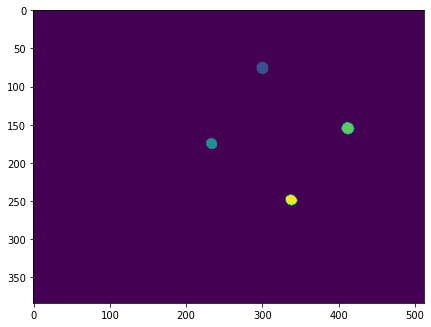

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(dim=1)[0].cpu().numpy(), vmin=0, vmax=4)

# Convert to onnx

In [20]:
import onnx
import torch.onnx
import onnxruntime as nxrun

In [21]:
torch.onnx.export(model,
                  X,
                  'model.onnx',
                  export_params=True,
                  verbose=False)

In [22]:
sess = nxrun.InferenceSession('model.onnx')
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
y = sess.run(None, {input_name: X.cpu().numpy()})[0]

In [23]:
y[0,0,0,0].item()

4.975112438201904

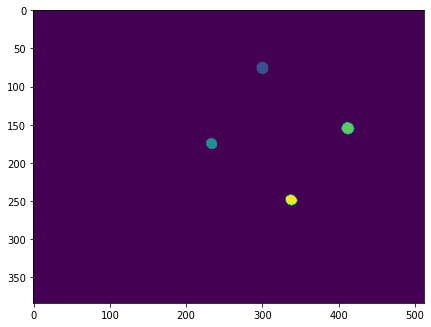

In [24]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(axis=1)[0], vmin=0, vmax=4)

# Onnx to tensorrt (32 bit)

In [25]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [26]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create engine

In [27]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 16
engine = builder.build_engine(network, config)

Save engine

In [28]:
with open('model_32.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [29]:
runtime = trt.Runtime(logger)
with open('model_32.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [30]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [31]:
with open('../../batches/X0.raw', 'rb') as f:
    f.readinto(X_h)

In [32]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [33]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize() 

In [34]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [35]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

2.85 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [37]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [38]:
y_h[0][0][0][0].item()

4.975111961364746

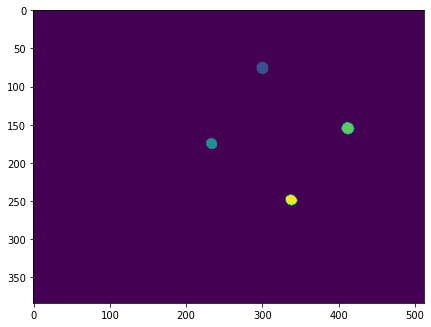

In [39]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

# Onnx to tensorrt (16 bit)

In [40]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [41]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create engine

In [42]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 16
config.set_flag(trt.BuilderFlag.FP16)
# config.set_flag(trt.BuilderFlag.STRICT_TYPES) # This will force it
engine = builder.build_engine(network, config)

Save engine

In [43]:
with open('model_16.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [44]:
runtime = trt.Runtime(logger)
with open('model_16.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [45]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [46]:
with open('../../batches/X0.raw', 'rb') as f:
    f.readinto(X_h)

In [47]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [48]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize() 

In [49]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [50]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

2.07 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [52]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [53]:
y_h[0][0][0][0].item()

4.98046875

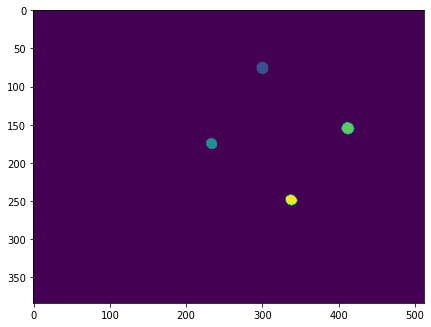

In [54]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

# Onnx to tensorrt (8 bit)

This is a little more complicated and requires doing 8 bit calibration

In [60]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [61]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create calibrator; documentation says Entropy Calibrator V2 is the recommended version for CNN based networks. It would be interesting to see how much of an effect calibration has on results.

In [62]:
class Int8Calibrator(trt.IInt8EntropyCalibrator2):
    def __init__(self, files_batch):
        super().__init__()
        self.files_batch = files_batch
        self.count = 0
        self.buf_h = cuda.pagelocked_empty(384*512, dtype=np.float32)
        self.buf_d = cuda.mem_alloc(self.buf_h.nbytes)
    
    def read_calibration_cache(self, *args, **kwargs): 
        return None
    
    def write_calibration_cache(self, cache, *args, **kwargs):
        pass
    
    def get_batch_size(self): 
        return 1
    
    def get_batch(self, *args, **kwargs): 
        if self.count < len(self.files_batch):
            with open(self.files_batch[self.count], 'rb') as f:
                f.readinto(self.buf_h)
            cuda.memcpy_htod(self.buf_d, self.buf_h) # I assume this is synchronous?
            self.count += 1
            return [int(self.buf_d)]
        else:
            return []

In [63]:
calibrator_int8 = Int8Calibrator(list(Path('../../batches').glob('*.raw')))

Create engine

In [64]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 30
config.set_flag(trt.BuilderFlag.INT8)
config.int8_calibrator = calibrator_int8
engine = builder.build_engine(network, config)

Save engine

In [65]:
with open('model_8.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [66]:
runtime = trt.Runtime(logger)
with open('model_8.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [67]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [68]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [69]:
with open(Path('../../batches/X0.raw'), 'rb') as f:
    f.readinto(X_h)

In [70]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize()   

In [71]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [72]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

1.47 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [74]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [75]:
y_h[0][0][0][0].item()

4.886321544647217

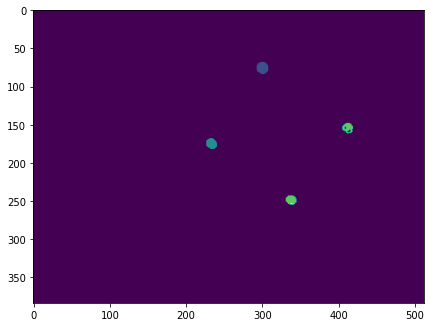

In [76]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

# Compare

Note that `int8` failed for sure. `int16` looks reasonable though.